# Predicción de Enfermedad Cardíaca: Explicación Paso a Paso

En este cuaderno vamos a ver cómo una computadora puede ayudarnos a predecir si una persona tiene enfermedad cardíaca (`HeartDisease`). Usaremos dos "modelos" (formas de predecir): **regresión logística** y **Random Forest**. También veremos qué factores de salud son más importantes para la predicción.

## ¿Qué aprenderás aquí?
- **Clasificación binaria**: El objetivo es responder a una pregunta de sí o no: ¿la persona tiene enfermedad cardíaca?
- **Interpretabilidad**: Queremos saber qué factores de salud (como el colesterol, la edad, etc.) influyen más en el resultado.
- **Métricas de clasificación**: Son formas de medir si el modelo acierta o se equivoca, por ejemplo: cuántas veces acierta (accuracy), qué tan bien separa sanos de enfermos (AUC), etc.

> **Nota:** No necesitas saber matemáticas ni programación para entender los conceptos. Los comentarios y explicaciones te guiarán paso a paso.

In [59]:
# PASO 1: Cargar los datos y ver cómo son
import pandas as pd  # Para manejar tablas de datos
import matplotlib.pyplot as plt  # Para hacer gráficos
import seaborn as sns  # Para hacer gráficos bonitos

# Leemos el archivo CSV con los datos de pacientes
df = pd.read_csv('heart.csv')

# Mostramos las primeras filas para ver cómo son los datos
print(df.head())  # Así vemos qué columnas hay y cómo son los valores

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


**Exploración:**  
Mira las columnas de la tabla. ¿Cuáles de estos datos crees que pueden estar relacionados con problemas del corazón? Por ejemplo: la edad, el tipo de dolor en el pecho, el sexo, el colesterol, etc.

> **Consejo:** Si no entiendes alguna palabra, ¡pregunta! Lo importante es tener curiosidad.

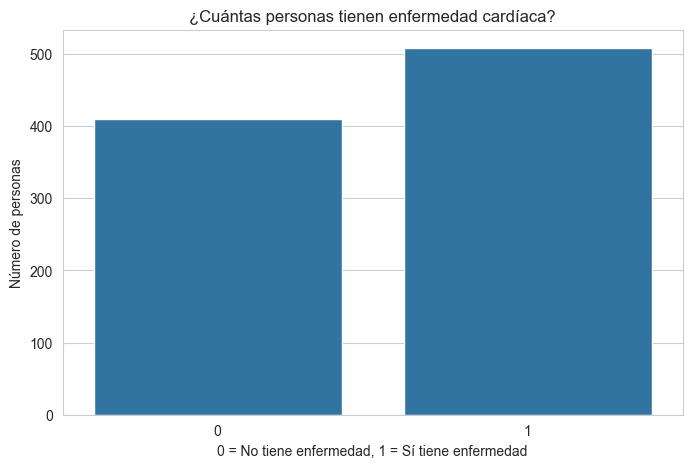

In [60]:
# PASO 2: Ver cuántas personas tienen enfermedad cardíaca y cuántas no
# Esto nos ayuda a saber si los datos están equilibrados (hay más sanos o más enfermos)
sns.countplot(x='HeartDisease', data=df)
plt.title('¿Cuántas personas tienen enfermedad cardíaca?')
plt.xlabel('0 = No tiene enfermedad, 1 = Sí tiene enfermedad')
plt.ylabel('Número de personas')
plt.show()

**Pregunta:**  
¿Hay más personas sanas o más personas con enfermedad cardíaca en los datos? Si hay muchos más de un grupo que de otro, el modelo puede aprender peor.

> **Ejemplo:** Si hay 90% sanos y 10% enfermos, el modelo podría aprender a decir siempre "sano" y acertar mucho, pero no sería útil.

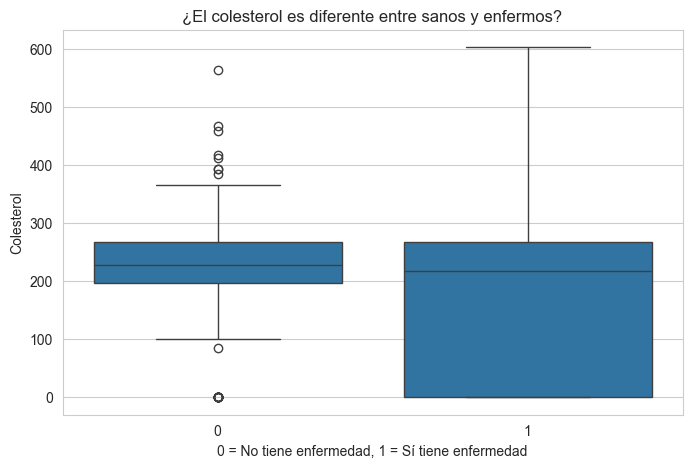

In [61]:
# PASO 3: Ver si el colesterol influye en la enfermedad
# Comparamos los valores de colesterol entre personas sanas y con enfermedad
sns.boxplot(x='HeartDisease', y='Cholesterol', data=df)
plt.title('¿El colesterol es diferente entre sanos y enfermos?')
plt.xlabel('0 = No tiene enfermedad, 1 = Sí tiene enfermedad')
plt.ylabel('Colesterol')
plt.show()

**Análisis:**  
¿Ves que las personas con enfermedad cardíaca suelen tener el colesterol más alto? Si es así, el colesterol podría ser un factor importante.

> **Recuerda:** Un factor importante es aquel que ayuda a diferenciar entre sanos y enfermos.

In [62]:
# PASO 4: Preparar los datos para el modelo
# Algunas columnas tienen palabras (como tipo de dolor), las convertimos a números (dummies)
cat_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']  # Estas son las columnas con palabras
df = pd.get_dummies(df, columns=cat_vars, drop_first=True)  # Creamos columnas nuevas con 0 y 1

# Mostramos cómo queda la tabla después de convertir a dummies
print(df.head())  # Ahora todo son números, ¡listo para el modelo!
print(df.count())  # Ver cuántos datos hay en cada columna para asegurarnos de que no falte nada

   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0   True               True              False             False   
1  False              False               True             False   
2   True               True              False             False   
3  False              False              False             False   
4   True              False               True             False   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0               True          False             False          False

**¿Por qué convertir a dummies?**  
Algunos datos, como el tipo de dolor en el pecho, no son números sino palabras. Los modelos de inteligencia artificial solo entienden números. Por eso, convertimos cada opción en una columna que vale 0 o 1 (por ejemplo: dolor tipo A = 1, si no = 0).

> **Ejemplo:** Si tienes "DolorTipo = A" y "DolorTipo = B", creamos dos columnas: una para A y otra para B, y ponemos 1 o 0 según corresponda.

In [63]:
# PASO 5: Separar los datos en entrenamiento y prueba
# Así podemos entrenar el modelo con una parte y comprobar si acierta con la otra
from sklearn.model_selection import train_test_split  # Herramienta para separar los datos

# X son las variables que usaremos para predecir, y es la respuesta (enfermedad sí/no)
X = df.drop(columns=['HeartDisease'])  # Todo menos la columna de respuesta
y = df['HeartDisease']  # La columna que queremos predecir

# 70% para entrenar, 30% para probar. random_state=8 hace que siempre salga igual.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ahora tenemos X_train, y_train para entrenar y X_test, y_test para comprobar

Accuracy: 0.8768115942028986
AUC: 0.9437064459930313
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       112
           1       0.92      0.87      0.89       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.87       276
weighted avg       0.88      0.88      0.88       276



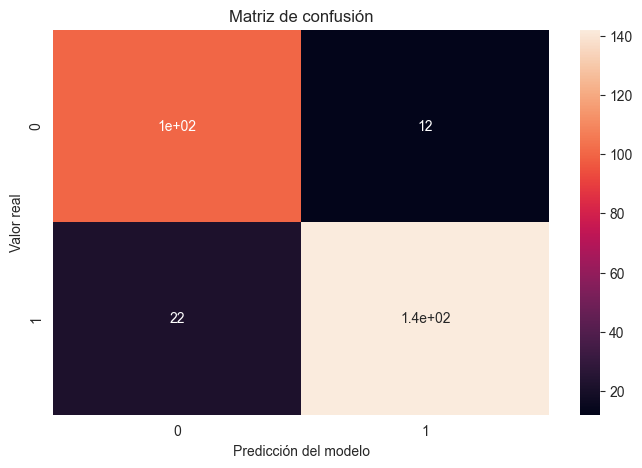

In [64]:
# PASO 6: Crear y probar el modelo de regresión logística
# Este modelo intenta encontrar una fórmula para predecir sí/no
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')  # Para no ver mensajes de advertencia
# Creamos el modelo y lo entrenamos con los datos de entrenamiento
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Hacemos predicciones con los datos de prueba
y_pred = logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
# Mostramos qué porcentaje acierta el modelo (accuracy)
print('Accuracy:', acc_logreg)

# Calculamos el AUC, que mide qué tan bien separa sanos de enfermos
print('AUC:', auc_logreg)

# Mostramos un reporte más detallado (precisión, recall, etc.)
print(classification_report(y_test, y_pred))

# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

**¿Qué es el AUC?**  
El AUC (Area Under Curve) es una forma de medir qué tan bien el modelo distingue entre personas sanas y personas con enfermedad. Si el AUC es 1, el modelo es perfecto; si es 0.5, el modelo no sabe distinguir (es como lanzar una moneda).

> **En resumen:** Cuanto más cerca de 1, mejor.

Random Forest Accuracy: 0.8804347826086957
Random Forest AUC: 0.9387249564459929
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       112
           1       0.90      0.90      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



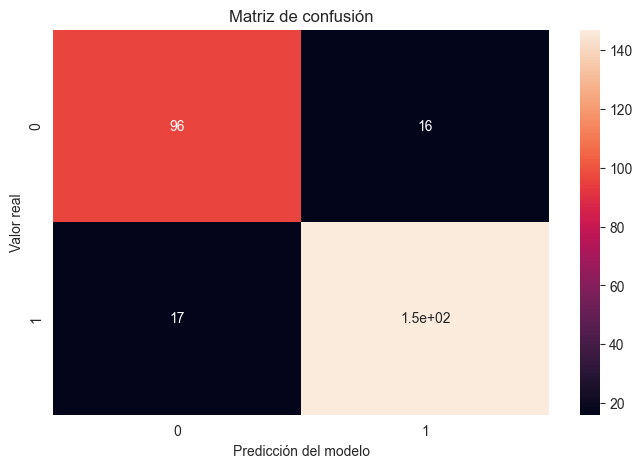

In [65]:
# PASO 7: Probar un modelo más avanzado: Random Forest
# Random Forest es un modelo que combina muchos árboles de decisión para mejorar la predicción
from sklearn.ensemble import RandomForestClassifier

# Creamos el modelo y lo entrenamos
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Hacemos predicciones con Random Forest
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
# Mostramos el porcentaje de aciertos y el AUC
print('Random Forest Accuracy:', acc_rf)
print('Random Forest AUC:', auc_rf)
print(classification_report(y_test, y_pred_rf))
# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

#### Reflexión final para todos:

- ¿Qué modelo acierta más, la regresión logística o el Random Forest? ¿Por qué crees que ocurre esto?
- ¿Qué factores de salud (variables) parecen ser los más importantes según los modelos?
- ¿Crees que sería útil en la vida real poder predecir así este tipo de enfermedades? ¿Por qué?

> **Recuerda:** Lo importante no es solo acertar, sino también entender por qué el modelo toma sus decisiones.

## Clasificación con Boosting

### Importamos librerias

In [66]:
# Manipulación y visualización de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de boosting y métricas
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import  r2_score, classification_report, confusion_matrix

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')  # Para no ver mensajes de advertencia
# Configuración de gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

### AdaBoost Classifier

AdaBoost - Accuracy: 0.87
AdaBoost - AUC: 0.93
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       112
           1       0.91      0.86      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276



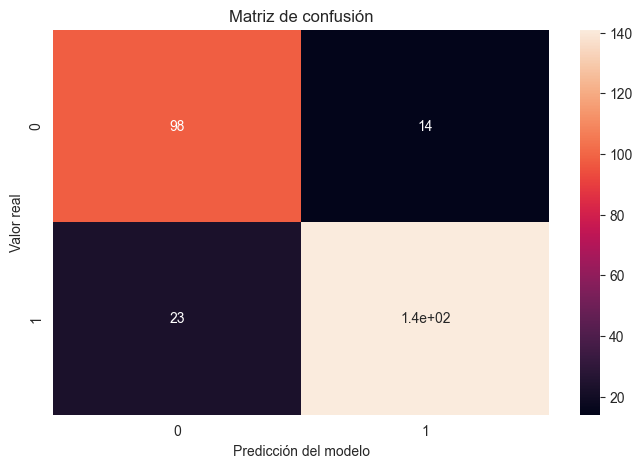

In [67]:
ada_dia = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_dia.fit(X_train, y_train)
y_dia_pred_ada = ada_dia.predict(X_test)
acc_dia_ada = accuracy_score(y_test, y_dia_pred_ada)
auc_dia_ada = roc_auc_score(y_test, ada_dia.predict_proba(X_test)[:,1])
print(f'AdaBoost - Accuracy: {acc_dia_ada:.2f}')
print(f'AdaBoost - AUC: {auc_dia_ada:.2f}')
print(classification_report(y_test, y_dia_pred_ada))

# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_dia_pred_ada), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

### Gradient Booting Classifier

Gradient Boosting - Accuracy: 0.87
Gradient Boosting - AUC: 0.94
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       112
           1       0.89      0.90      0.89       164

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



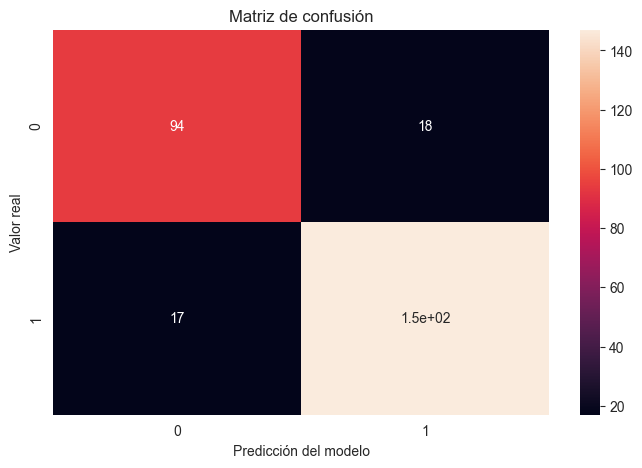

In [68]:
gbr_dia = GradientBoostingClassifier(n_estimators=50, random_state=42)
gbr_dia.fit(X_train, y_train)
y_dia_pred = gbr_dia.predict(X_test)
acc_dia = accuracy_score(y_test, y_dia_pred)
auc_dia = roc_auc_score(y_test, gbr_dia.predict_proba(X_test)[:,1])
print(f'Gradient Boosting - Accuracy: {acc_dia:.2f}')
print(f'Gradient Boosting - AUC: {auc_dia:.2f}')
print(classification_report(y_test, y_dia_pred))

# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_dia_pred), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

### XGBoost Classifier

XGBoost - Accuracy: 0.86
XGBoost - AUC: 0.93
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       112
           1       0.90      0.85      0.88       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276



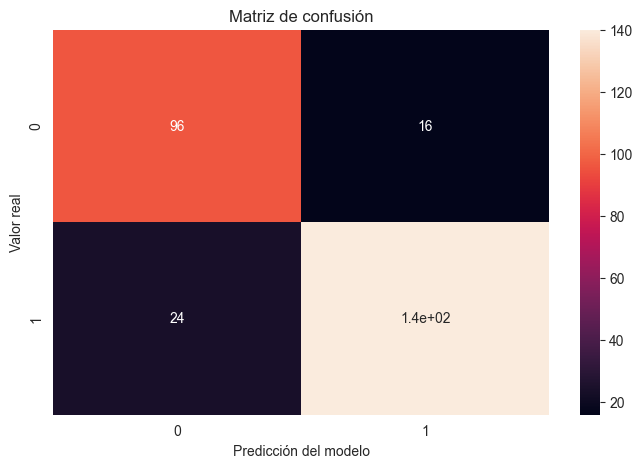

In [69]:
xgb_dia = xgb.XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)
xgb_dia.fit(X_train, y_train)
y_dia_pred_xgb = xgb_dia.predict(X_test)
acc_dia_xgb = accuracy_score(y_test, y_dia_pred_xgb)
auc_dia_xgb = roc_auc_score(y_test, xgb_dia.predict_proba(X_test)[:,1])
print(f'XGBoost - Accuracy: {acc_dia_xgb:.2f}')
print(f'XGBoost - AUC: {auc_dia_xgb:.2f}')
print(classification_report(y_test, y_dia_pred_xgb))

# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_dia_pred_xgb), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

### LightGBM Classifier

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

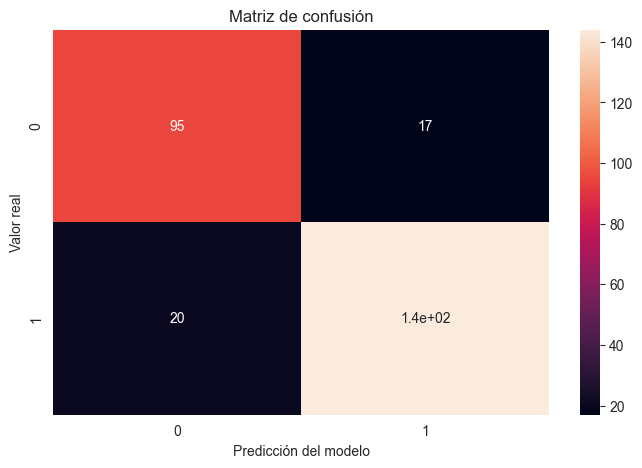

In [70]:
lgbm_dia = lgb.LGBMClassifier(n_estimators=50, random_state=42)
lgbm_dia.fit(X_train, y_train)
y_dia_pred_lgbm = lgbm_dia.predict(X_test)
acc_dia_lgbm = accuracy_score(y_test, y_dia_pred_lgbm)
auc_dia_lgbm = roc_auc_score(y_test, lgbm_dia.predict_proba(X_test)[:,1])
print(f'LightGBM - Accuracy: {acc_dia_lgbm:.2f}')
print(f'LightGBM - AUC: {auc_dia_lgbm:.2f}')
print(classification_report(y_test, y_dia_pred_lgbm))

# Mostramos la matriz de confusión: cuántos aciertos y errores
sns.heatmap(confusion_matrix(y_test, y_dia_pred_lgbm), annot=True)
plt.title('Matriz de confusión')
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.show()

### Comparativa Heart Failure Prediction

,Modelo,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.876812,0.922078,0.865854,0.893082,0.943706
1,Random Forest,0.880435,0.901840,0.896341,0.899083,0.938725
2,AdaBoost,0.865942,0.909677,0.859756,0.884013,0.929524
3,GradientBoosting,0.873188,0.890909,0.896341,0.893617,0.941474
4,XGBoost,0.855072,0.897436,0.853659,0.875000,0.931892
5,LightGBM,0.865942,0.894410,0.878049,0.886154,0.933526


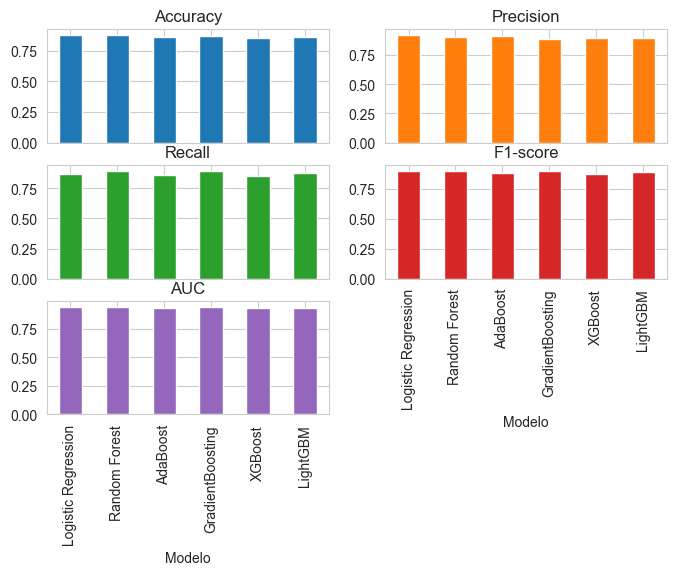

In [71]:
# --- Comparativa Heart Failurre (Clasificación) ---
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular métricas adicionales para cada modelo
precision_logreg = precision_score(y_test, logreg.predict(X_test))
recall_logreg = recall_score(y_test, logreg.predict(X_test))
f1_logreg = f1_score(y_test, logreg.predict(X_test))

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf) 
f1_rf = f1_score(y_test, y_pred_rf)

precision_dia_ada = precision_score(y_test, y_dia_pred_ada)
recall_dia_ada = recall_score(y_test, y_dia_pred_ada)
f1_dia_ada = f1_score(y_test, y_dia_pred_ada)

precision_dia = precision_score(y_test, y_dia_pred)
recall_dia = recall_score(y_test, y_dia_pred)
f1_dia = f1_score(y_test, y_dia_pred)

precision_dia_xgb = precision_score(y_test, y_dia_pred_xgb)
recall_dia_xgb = recall_score(y_test, y_dia_pred_xgb)
f1_dia_xgb = f1_score(y_test, y_dia_pred_xgb)

precision_dia_lgbm = precision_score(y_test, y_dia_pred_lgbm)
recall_dia_lgbm = recall_score(y_test, y_dia_pred_lgbm)
f1_dia_lgbm = f1_score(y_test, y_dia_pred_lgbm)

resultados_dia = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'LightGBM'],
    'Accuracy': [acc_logreg, acc_rf, acc_dia_ada, acc_dia, acc_dia_xgb, acc_dia_lgbm],
    'Precision': [precision_logreg, precision_rf, precision_dia_ada, precision_dia, precision_dia_xgb, precision_dia_lgbm],
    'Recall': [recall_logreg, recall_rf, recall_dia_ada, recall_dia, recall_dia_xgb, recall_dia_lgbm],
    'F1-score': [f1_logreg, f1_rf, f1_dia_ada, f1_dia, f1_dia_xgb, f1_dia_lgbm],
    'AUC': [auc_logreg, auc_rf, auc_dia_ada, auc_dia, auc_dia_xgb, auc_dia_lgbm]
})
display(resultados_dia)
resultados_dia.plot(x='Modelo', y=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'], kind='bar', subplots=True, layout=(3,2), legend=False, title=['Accuracy','Precision','Recall','F1-score', 'AUC'])
plt.tight_layout()
plt.show()